## CILP & Cross-Modal Fine-Tuning Assessment

This notebook builds on previous insights (`01_*`, `02_*`, `03_*`) and the `Embedder` class to perform cross-modal RGB→LiDAR projection and fine-tuning. The workflow includes:

1. **LiDAR Classifier Training:** Train `LidarClassifier` on LiDAR images and save the best checkpoint.  
2. **Contrastive Image-LiDAR Pretraining (CILP):** Train two `Embedder`s on RGB and LiDAR images with a CLIP-like contrastive loss (`EfficientCILPModel`) and save the best checkpoint.  
3. **Cross-Modal Projection:** Train a `CrossModalProjector` to optimally map RGB embeddings to the LiDAR embedding space.  
4. **RGB→LiDAR Fine-Tuning:** Fine-tune the combined `CILP.Embedder + CrossModalProjector + LidarClassifier.classifier` pipeline with a specific optimizer, learning rate, and layer-unfreeze strategy.  

All models use the same `Embedder` backbone from notebooks `02_*` and `03_*`, which outputs a $200$-dimensional feature map after $4$ convolutional layers and employs MaxPool downsampling (kernel=$2$). The objective is to achieve $\geq 95\%$ accuracy** on RGB inputs compared to the baseline $50\%$ accuracy of a LiDAR-only classifier.  

The first section defines the experiment configuration, including path setup and initialization of the relevant data loaders.

In [1]:
%load_ext autoreload
%autoreload 2

import wandb
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import json 
import torch
import torch.nn as nn
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

import pandas as pd

from handsoncv.datasets import CILPFusionDataset
from handsoncv.models import (
    LidarClassifier, EfficientCILPModel, CrossModalProjector, RGB2LiDARClassifier
)
from handsoncv.training import train_fusion_cilp_model
from handsoncv.utils import (
    set_seed, seed_worker, search_checkpoint_model, evaluate_model
)

from torchvision import transforms
from torch.utils.data import DataLoader

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Folders we frequently use across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-2")

CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
ROOT_DATA = "~/Documents/repos/BuildingAIAgentsWithMultimodalModels/data/assessment/"
IMG_SIZE = 64
BATCH_SIZE = 32

Using GPU: NVIDIA GeForce RTX 3090
cuda


In the following cell, we set a fixed random seed to ensure reproducible data shuffling in the DataLoader multiprocessing pipeline. We then use a custom data-loading function implemented in `src/datasets.py`, which constructs the training and validation splits from predefined sample lists. These lists were generated and saved earlier in `01_dataset_exploration.ipynb`. For details on the creation procedure, refer to `01_dataset_exploration.ipynb`, and for information on the subset size used in the experiments, see the configuration logs in the public [handsoncv-cilp-assessment project link](https://wandb.ai/handsoncv-research/handsoncv-cilp-assessment?nw=nwuserguarinovanessaemanuela).

In [2]:
# Load split dictionary previouslu created with 01_dataset_exploration.ipynb
mapping_file = "subset_splits.json"
with open(f"{ROOT_PATH}/{mapping_file}", "r") as f:
    splits = json.load(f)
    
SEED = splits["seed"] # From .json file created through notebook 01_dataset_exploration.ipynb 
set_seed(SEED)

# Instantiate Dataset and relative Transformation
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
])

train_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["train"], transform=img_transforms)
val_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["val"], transform=img_transforms)

# Create a Generator object to pass to the dataLoaders
g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=2, worker_init_fn=seed_worker, generator=g)

print(f"Ready to train with {len(train_ds)} training pairs and {len(val_ds)} validation pairs.")

Seeds set to 42 for reproducibility.
Ready to train with 4799 training pairs and 1200 validation pairs.


Finally, the last configuration cell ensures a balanced distribution of classes within the training and validation batches. This is particularly important because **the datasets provided in the NVIDIA notebooks produced batches containing only a single class**, leading to unreliable accuracy estimates. These three configuration cells are shared across the experimental notebooks `02_*`, `03_*`, and `04_*`.

In [3]:
assert set(train_ds.sample_ids).isdisjoint(set(val_ds.sample_ids)), "DATA LEAKAGE DETECTED!"

leaked_ids = set(train_ds.sample_ids).intersection(set(val_ds.sample_ids))
print(f"Found {len(leaked_ids)} overlapping IDs.")
print(f"Example leaked IDs: {list(leaked_ids)[:10]}")

train_labels = next(iter(train_loader))[-1].cpu().numpy()
val_labels = next(iter(val_loader))[-1].cpu().numpy()
class_prior_train, class_prior_val = train_labels.mean(), val_labels.mean()

print(f"Class prior average in first training batch: {class_prior_train:.4f}, and validation batch: {class_prior_val:.4f}")

if class_prior_train < 0.01 or class_prior_train > 0.99:
    raise ValueError("The training batch is extremely imbalanced "
        f"(class prior = {class_prior_train:.4f}). "
        "It will cause the model to memorize label ordering. "
        "Please recreate the dataset splits."
    )

Found 0 overlapping IDs.
Example leaked IDs: []


Class prior average in first training batch: 0.2812, and validation batch: 0.5625


The following cell defines two parameters shared across all four experiments. These are set at a high level to avoid repetition throughout training and models initialization.

In [4]:
SUBSET_SIZE = len(train_ds) + len(val_ds) 
INTERM_FUSION_EMB_DIM = 200

### Train a LiDAR-Only Classifier (Step 5.1a)

**A Note on the Training Scheme.** In the following cell, we train a LiDAR-only classifier using the `dynamic_train_fusion_cilp_model` function (implemented in `src/training.py`). This dynamic training routine is consistently applied across all training tasks in this notebook, including LiDAR classifier training, CILP pretraining, cross-modal projection, and RGB→LiDAR fine-tuning, ensuring uniform logging, evaluation, and checkpointing application.

All training tasks, except for RGB→LiDAR fine-tuning (which uses a dedicated optimization scheme discussed later), use the following setup:
```python
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
```

Here, Adam ensures stable convergence, while the cosine annealing scheduler gradually reduces the learning rate to allow larger updates early in training, avoid getting stuck in local minima, and promote smoother convergence.

**Model and Logging Description.** All relevant training artifacts - including the first validation predictions, training and validation losses, accuracy, learning rate schedule, GPU memory usage, checkpoints, model parameters and full configuration logs - are recorded and can be inspected under the run name `5.1a_Lidar_Only` at the [handsoncv-cilp-assessment project link](https://wandb.ai/handsoncv-research/handsoncv-cilp-assessment?nw=nwuserguarinovanessaemanuela). Please, consider the latest run, as the previous one were performed and left for experimental purposes. 

From an architectural perspective, the `LidarClassifier` consists of two main components:
1. A modality-specific `Embedder`, which processes raw 4-channel LiDAR inputs and produces intermediate spatial feature maps of size $[B, 200, 4, 4]$.
2. A lightweight fully connected classification head that maps these features to the final class logits.

This classifier serves a dual role in the overall pipeline. First, it provides a well-converged LiDAR-only baseline for the cube-versus-sphere classification task, despite the inherent risk of overfitting due to the simplistic nature of the dataset. Second, its classification head (`lidar_model.classifier`) will be reused in Step 5.3 as the final prediction layer of the `RGB2LiDARClassifier`, where it will be fine-tuned on projected RGB features to improve cross-modal performance.

> **Caveat.** 
> To improve model generalizability - especially when evaluated on data of a different nature - data augmentation techniques such as random scaling (to encourage learning from partial geometry) and color jitter (to reduce reliance on limited appearance variability) could be applied. Additionally, regularization strategies such as dropout, batch normalization, or explicit loss regularizers may further mitigate overfitting. However, given the simplicity of the task (as also reflected in the NVIDIA lab setup), the absence of these measures still allows meaningful results and analysis. We therefore leave such extensions to future work beyond the scope of this assignment.

In [ ]:
# Configuration to fufill logging requirement
EPOCHS = 20
LEARNING_RATE = 1e-3

# Set Seed again for Ensuring Same Model Initialization at Every Run
SEED = splits["seed"]
set_seed(SEED)

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.1a_Lidar_Only",
    config={
        "architecture": "LidarClassifier",
        "fusion_strategy": "single_modality",
        "downsample_mode": "maxpool",
        "embedding_size": INTERM_FUSION_EMB_DIM,
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer_type": "Adam",
        "subset_size": SUBSET_SIZE,
        "seed": splits["seed"]
    }
)

# Instantiate LiDAR Classifier 
lidar_model = LidarClassifier(emb_dim_interm=INTERM_FUSION_EMB_DIM, num_classes=1).to(DEVICE)

# Define Optimizer and Scheduler
optimizer = torch.optim.Adam(lidar_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Train and Store Relevant Metrics 
metrics_lidar = train_fusion_cilp_model(
    lidar_model, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.BCEWithLogitsLoss(), 
    device=DEVICE,
    epochs=EPOCHS, 
    scheduler=scheduler, 
    task_mode="lidar-only"
)

wandb.finish()

Seeds set to 42 for reproducibility.


wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 0: Val Loss: 0.6931, Acc: 50.51% | Mem: 125.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 1: Val Loss: 0.2278, Acc: 90.79% | Mem: 125.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 2: Val Loss: 0.0127, Acc: 99.41% | Mem: 125.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 3: Val Loss: 0.0106, Acc: 99.66% | Mem: 125.5MB
Epoch 4: Val Loss: 0.0180, Acc: 99.58% | Mem: 125.5MB
Epoch 5: Val Loss: 0.0119, Acc: 99.92% | Mem: 125.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_

accuracy,▁▇██████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time_sec,█▂▁▁▂▃▂▂▁▂▄▁▁▁▂▂▁▁▅▃
learning_rate,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
peak_gpu_mem_mb,▁███████████████████
train_loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,99.91554
epoch,19
epoch_time_sec,2.82636
learning_rate,1e-05


### Contrastive Image–LiDAR (CILP Alignment - Step 5.1b)

In this step, we perform Contrastive Image–LiDAR Pretraining (CILP) to align RGB and LiDAR representations in a shared latent space. Following a CLIP-style objective, paired RGB–LiDAR samples are encouraged to have high similarity, while non-matching pairs within the same batch act as negatives.

We implement an optimized variant, `EfficientCILPModel`, which improves upon the NVIDIA baseline by:
- using dot-product similarity with a learnable temperature (`logit_scale`) providing better optimization dynamics compared to fixed similarity scaling;
- avoiding explicit tensor repetition, making the implementation more efficient and scalable;  

Both modalities are encoded using the same `Embedder` backbone and produce normalized 1D embeddings. The resulting $[B, B]$ similarity matrix - where $B$ is the validation batch size - is used with a contrastive loss to learn cross-modal alignment.

> **Caveats.**
> 1. Due to temperature scaling, the initial contrastive loss ($\approx 0.8–1.0$ for $B=32$) is lower than the classical InfoNCE baseline $log(B) ≈ 3.46$, which is expected and not an issue. Our diagonal similarities (correct pairs) will be higher than off-diagonal (negatives) compared to the Nvidia Lab's `CILPModel` class training. 
> 2. Given that the LiDAR-only classifier is trained for at least 20 epochs and the dataset is synthetic—leading to rapid overfitting—we train the `EfficientCILPModelz for 25 > epochs. Shorter training runs did not fully saturate off-diagonal similarity improvements, and the extended training ensures stronger alignment between matching RGB–LiDAR embedding pairs.

All relevant training artifacts - including the first validation predictions, training and validation losses, accuracy, learning rate schedule, GPU memory usage, checkpoints, model parameters and full configuration logs - are recorded and can be inspected under the run name `5.1b_CILP_Contras` at the [handsoncv-cilp-assessment project link](https://wandb.ai/handsoncv-research/handsoncv-cilp-assessment?nw=nwuserguarinovanessaemanuela). Please, consider the latest run, as the previous one were performed and left for experimental purposes. 

Seeds set to 42 for reproducibility.


wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
Epoch 0: Val Loss: 0.9311, Acc: 0.00% | Mem: 219.6MB
Accuracy not applicable to the embedding alignment task -> Similarity matrix (first 8x8):
[[0.822 0.376 0.454 0.455 0.475 0.304 0.667 0.588]
 [0.371 0.824 0.673 0.601 0.331 0.471 0.331 0.689]
 [0.426 0.656 0.83  0.827 0.371 0.383 0.331 0.492]
 [0.434 0.65  0.802 0.815 0.35  0.358 0.334 0.461]
 [0.474 0.333 0.398 0.37  0.858 0.543 0.458 0.457]
 [0.303 0.612 0.489 0.433 0.57  0.862 0.486 0.483]
 [0.796 0.343 0.261 0.306 0.394 0.49  0.888 0.336]
 [0.415 0.675 0.494 0.397 0.461 0.508 0.357 0.864]]
Mean diag: 0.691, Mean off-diag: -0.061
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
Epoch 1: Val Loss: 0.6944, Acc: 0.00% | Mem: 219.6MB
Accuracy not applicable to the embedding alignment task -> Similarity matrix (f

/home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/src/handsoncv/visualization.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 4))


Epoch 21: Val Loss: 0.1638, Acc: 0.00% | Mem: 219.6MB
Accuracy not applicable to the embedding alignment task -> Similarity matrix (first 8x8):
[[0.895 0.401 0.469 0.383 0.438 0.452 0.525 0.481]
 [0.388 0.912 0.591 0.592 0.689 0.448 0.639 0.517]
 [0.324 0.493 0.927 0.733 0.581 0.466 0.591 0.494]
 [0.351 0.578 0.737 0.912 0.523 0.484 0.472 0.272]
 [0.361 0.704 0.54  0.516 0.923 0.503 0.405 0.54 ]
 [0.485 0.434 0.483 0.489 0.442 0.921 0.363 0.469]
 [0.447 0.645 0.663 0.432 0.462 0.364 0.934 0.623]
 [0.422 0.505 0.531 0.312 0.518 0.457 0.63  0.929]]
Mean diag: 0.838, Mean off-diag: -0.005
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
Epoch 22: Val Loss: 0.1633, Acc: 0.00% | Mem: 219.6MB
Accuracy not applicable to the embedding alignment task -> Similarity matrix (first 8x8):
[[0.885 0.404 0.468 0.387 0.434 0.452 0.511 0.483]
 [0.395 0.908 0.595 0.586 0.683 0.449 0.651 0.513]
 [0.327 0.487 0.926 0.7

accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch_time_sec,█▁▂▃▃▂▂▂▃▂▂▁▁▁▂▂▁▂▂▁▆▁▁▁▁
learning_rate,█████▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁
peak_gpu_mem_mb,▁████████████████████████
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0
epoch,24
epoch_time_sec,2.82546
learning_rate,0.0


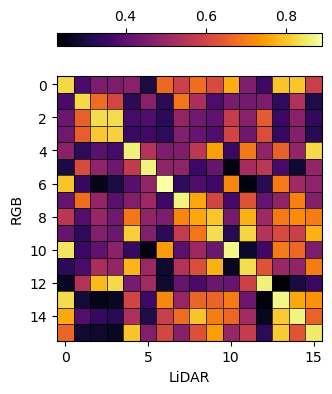

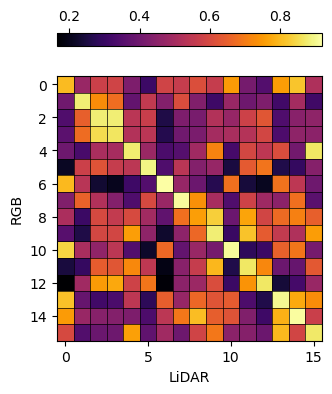

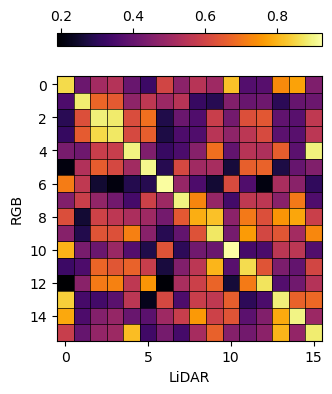

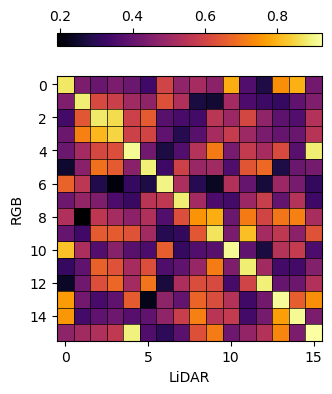

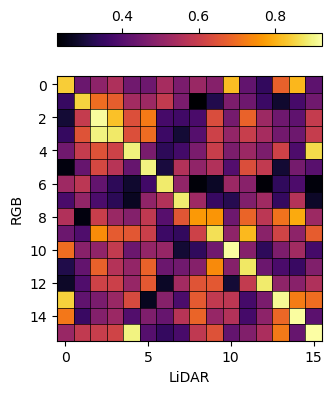

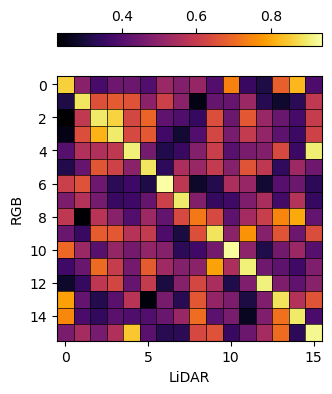

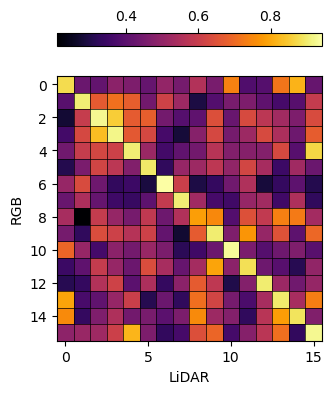

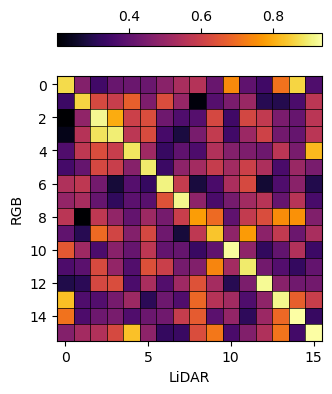

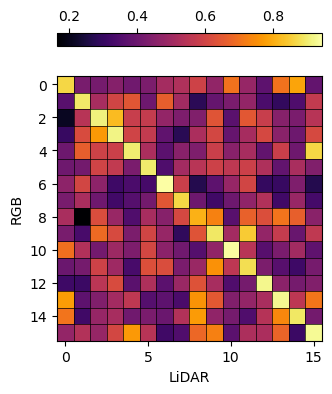

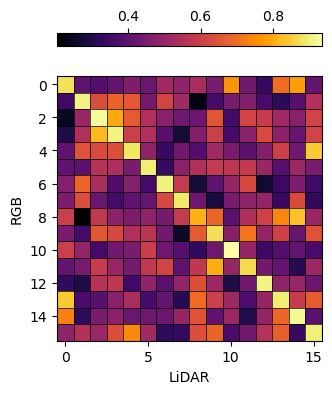

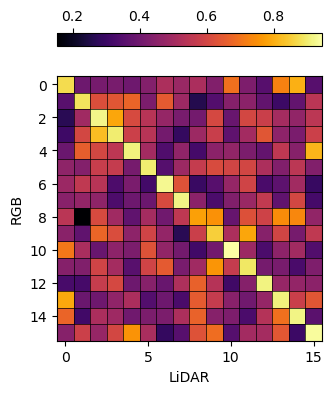

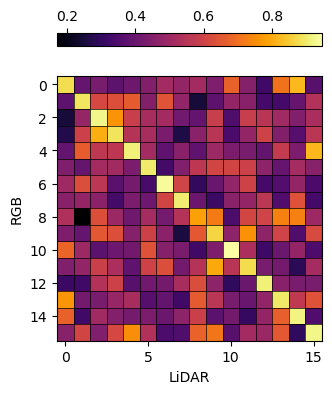

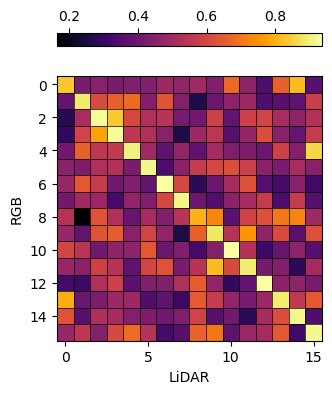

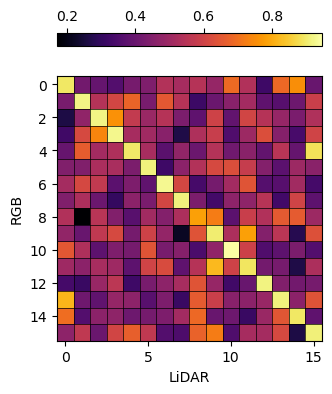

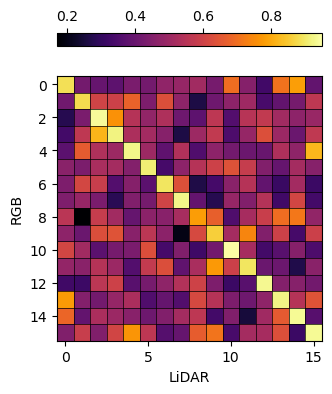

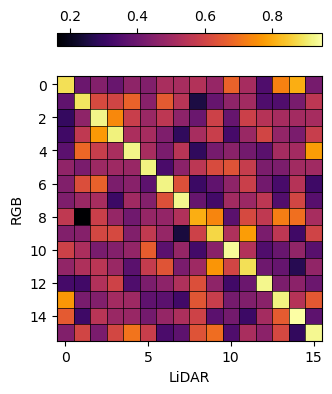

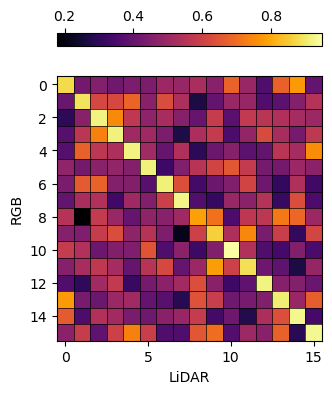

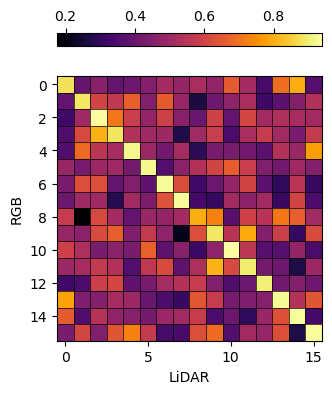

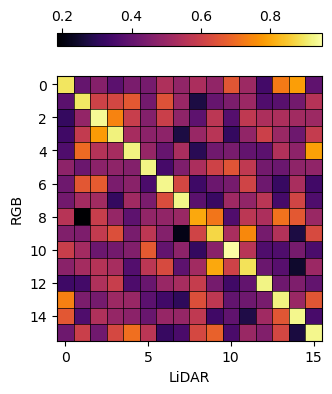

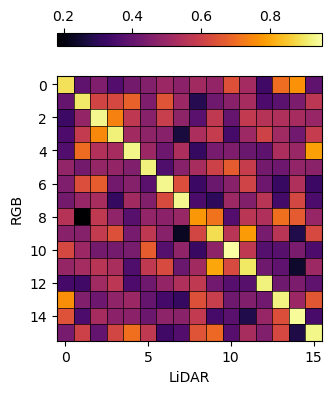

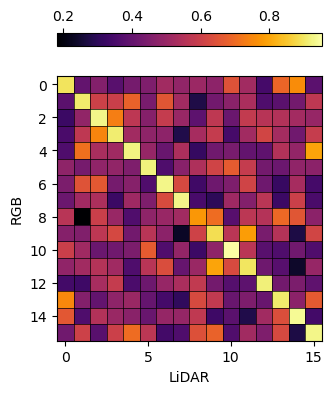

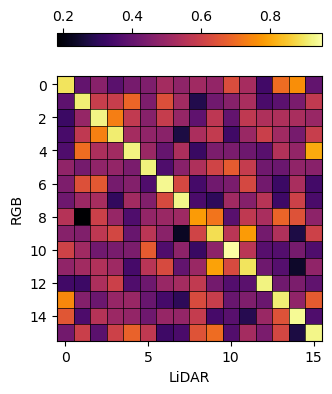

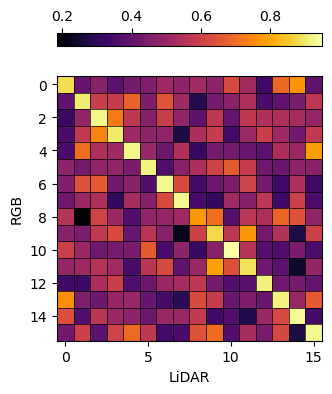

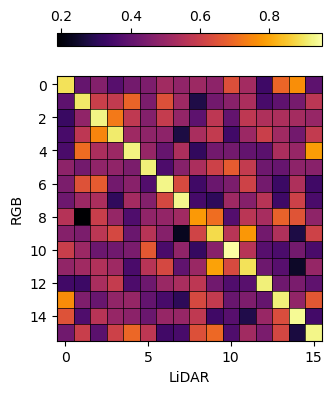

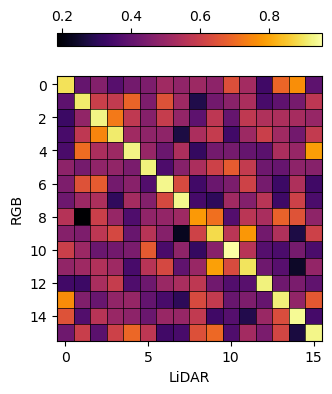

In [5]:
# Configuration to fufill logging requirement
# Optimization choices based upon Nvidia 05_Assessment CILP training scheme
EPOCHS = 25
LEARNING_RATE = 1e-4 

# Set Seed again for Ensuring Same Model Initialization at Every Run
SEED = splits["seed"]
set_seed(SEED)

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.1b_CILP_Contrastive",
    config={
        "architecture": "CILPModel",
        "fusion_strategy": "contrastive",
        "downsample_mode": "maxpool",
        "embedding_size": INTERM_FUSION_EMB_DIM,
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer_type": "Adam",
        "subset_size": SUBSET_SIZE,
        "seed": splits["seed"]
    }
)

# Instantiate CILP Model 
cilp_model = EfficientCILPModel(emb_dim_interm=INTERM_FUSION_EMB_DIM, emb_dim_late=INTERM_FUSION_EMB_DIM).to("cuda") #CILPModel

# Define Optimizer and Scheduler
optimizer = torch.optim.Adam(cilp_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Train and Store Relevant Metrics 
metrics_cilp = train_fusion_cilp_model(
    cilp_model, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.CrossEntropyLoss(), # CE used as contrastive loss for CILP
    device="cuda", 
    epochs=EPOCHS, 
    scheduler=scheduler, 
    task_mode="contrastive"
)

# TASK 5.1b CHECK REQUIREMENT:
check_value = 0.8 # ! As batch (B)-based expected threshold to hit instead of 3.2 (=log(B)) !
if metrics_cilp['val_loss'] < check_value:
    print(f"✅ Success! CILP Val Loss {metrics_cilp['val_loss']:.4f} is below {check_value}")

wandb.finish()

### Cross-Modal Projector (Step 5.2)

In this step, we train a `CrossModalProjector`, a multi-layer perceptron (MLP) designed to map compressed RGB embeddings into the high-dimensional LiDAR feature space that serves an input to the `LidarClassifier.classifier`. This model serves as the "bridge" in the RGB→LiDAR pipeline, enabling the use of an RGB encoder while leveraging a classifier originally trained on LiDAR features. Since this step is critical for enabling effective cross-modal fine-tuning with RGB-only data, and after aligning matching RGB–LiDAR embeddings via CILP, the Projector is trained longer than other architectures ($\geq 40$ epochs). Its design allows a gradual mapping of RGB embeddings to LiDAR space while mitigating internal covariate shift through `BatchNorm` layers.

Architecture:
- Input: RGB embeddings (`rgb_dim = 200` from the `CILP.Embedder`).  
- Hidden layers: Two fully connected layers with BatchNorm and ReLU activations (1024 → 2048).  
- Output: Projected vector matching the LiDAR embedding dimension (`lidar_dim=3200` for (200×4×4) feature maps).  

Training Scheme:
- The projector is trained using a*mean squared error (MSE) loss between its output and the frozen LiDAR embeddings as target from the pre-trained `LidarClassifier.Embedder`.  
- RGB embeddings are computed in evaluation mode to prevent gradient flow into the pre-trained `CILP.Embedder`.  
- Models' optimzier and learning rate are described in Step 5.1a of this notebook in the note dedicated to the Training Scheme  
- Only the projector's parameters are updated; all other components remain frozen.  

> **Caveat on Cross-Modal Projector Validation Loss.** In our setup, the validation loss starts around $\approx 0.4$, rather than the $\approx 2.5$ reported in the assignment description. This difference arises because the initial validation loss depends on the specific validation batch, the network's weight initialization, and the variance of the predicted RGB-projected embeddings relative to the learned LiDAR embeddings. In our case, this variance is much smaller than the variance of the sum of two independent standardized variables, which would produce a value closer to $2$.

In the following cell, we load the pretrained models from previous steps using the `search_checkpoint_model` function. By default:  

- `lidar_model` and `cilp_model` are set to `.eval()` mode with their parameters' gradients frozen.  
- The `CrossModalProjector` remains in training mode, as it will be the main component fine-tuned in the final RGB→LiDAR step.

In [6]:
new_lidar_model = LidarClassifier(emb_dim_interm=INTERM_FUSION_EMB_DIM, num_classes=1).to("cuda")
new_cilp_model = EfficientCILPModel(emb_dim_interm=INTERM_FUSION_EMB_DIM, emb_dim_late=INTERM_FUSION_EMB_DIM).to("cuda") #CILPModel

lidar_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_lidar_model, task_mode="lidar-only")
cilp_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_cilp_model,task_mode="contrastive")

Loaded lidar-only model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
        Using instantiated model in `.eval()` mode.
Loaded contrastive model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
        Using instantiated model in `.eval()` mode.


We now train our `CrossModalProjector`. All relevant training artifacts - including the first validation predictions, training and validation losses, accuracy, learning rate schedule, GPU memory usage, checkpoints, model parameters and full configuration logs - are recorded and can be inspected under the run name `5.2_Projector_MSE` at the [handsoncv-cilp-assessment project link](https://wandb.ai/handsoncv-research/handsoncv-cilp-assessment?nw=nwuserguarinovanessaemanuela). Please, consider the latest run, as the previous one were performed and left for experimental purposes. 

In [7]:
# Configuration to fufill logging requirement
# Choices based upon Nvidia 05_Assessment CILP training scheme
EPOCHS = 40
LEARNING_RATE = 1e-3

# Set Seed again for Ensuring Same Model Initialization at Every Run
SEED = splits["seed"]
set_seed(SEED)

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.2_Projector_MSE",
    config={
        "architecture": "CrossModalProjector",
        "fusion_strategy": "projector",
        "downsample_mode": "maxpool",
        "embedding_size": INTERM_FUSION_EMB_DIM,
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer_type": "Adam",
        "subset_size": SUBSET_SIZE,
        "seed": splits["seed"]
    }
)

# Instantiate CrossModalProjector  
# Lidar intermediate flat dimension: 200 * 4 * 4 = 3200
projector = CrossModalProjector(rgb_dim=INTERM_FUSION_EMB_DIM, lidar_dim=INTERM_FUSION_EMB_DIM * 4 * 4).to("cuda")

# We Pass the Frozen Re-Loaded Best Models to the Loop via cilp_extras Dictionary
extras = {
    'img_enc': cilp_model.img_embedder, 
    'lidar_cnn': lidar_model 
}

# Define Optimizer and Scheduler
optimizer = torch.optim.Adam(projector.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Train and Store Relevant Metrics 
metrics_proj = train_fusion_cilp_model(
    projector, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.MSELoss(), # Projector criterion: MSE
    device="cuda", 
    epochs=EPOCHS, 
    task_mode="projector", 
    scheduler=scheduler,
    cilp_extras=extras
)

# TASK 5.2 CHECK REQUIREMENT:
check_value = .5 - (.4*.5) # Set a target of reducing the initial validation MSE by 40%.
if metrics_proj['val_loss'] < check_value:
    print(f"✅ Success! Projector MSE {metrics_proj['val_loss']:.6f} is below {check_value}")

wandb.finish()

Seeds set to 42 for reproducibility.


wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 0: Val Loss: 0.490337, Acc: 0.00% | Mem: 261.3MB
Accuracy not applicable to the cross-modal projector task
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 1: Val Loss: 0.429022, Acc: 0.00% | Mem: 261.3MB
Accuracy not applicable to the cross-modal projector task
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 2: Val Loss: 0.389261, Acc: 0.00% | Mem: 261.3MB
Accuracy not applicable to the cross-modal projector task
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 3: Val Loss: 0.386216, Acc: 0.00% | Mem: 261.3MB
Accuracy not applicable to the cross-modal projector task
Save

accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_time_sec,█▃▃▂▃▃▂▂█▂▃▂▂▃▁▂▁▁▃▂▄▂▂▂▂▃▂▂▃▂▁▂▆▁▁▁▁▁▃▂
learning_rate,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
peak_gpu_mem_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0
epoch,39
epoch_time_sec,2.76018
learning_rate,0.0


### Step 5.3 Final Classifier Fine-Tuning 

We have now reached the last step of our cross-modal projection strategy. In this step, we instantiate the `RGB2LiDARClassifier` using:

1. `EfficientCILPModel.Embedder` – set to `.eval()` mode to extract lower-dimensional embeddings (32×200) from the 4×64×64 RGB images.  
2. `CrossModalProjector` – set to `.train()` mode with unfrozen parameters to fine-tune the mapping of RGB embeddings into the input dimensionality expected by `LidarClassifier.classifier`.  
3.`LidarClassifier.classifier` – set to `.eval()` mode to classify the projected embeddings into cubes or spheres.

Given the high accuracy of the pre-composed model, the fine-tuning strategy focuses solely on the projector. The modified training setup is:

```python
optimizer = torch.optim.Adam([
    {'params': final_cilp_classifier.projector.parameters(), 'lr': 3e-5}, 
], weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs+5)
```

- The small learning rate ensures minimal disturbance to the already well-aligned embeddings, allowing the model to correct only a few mispredicted validation samples.
- `CosineAnnealingLR` gradually decreases the learning rate over training, enabling smoother convergence and avoiding overshooting the minimum. We set `T_max` slightly to be bigger than the number of total epochs, to avoid a zero-learning trap.
- Weight decay acts as a regularizer, preventing overfitting during this fine-tuning stage.

> **Caveat.** Even higher performance could be achieved by selectively unfreezing parts of the classifier head, the final linear layers of the RGB Embedder, or by applying different learning rates per component, allowing more sophisticated fine-tuning strategies.

In the following cell, we load the pretrained models from previous steps using the `search_checkpoint_model` function. By default:  

- `lidar_model` and `cilp_model` are set to `.eval()` mode with their parameters' gradients frozen.  
- The `CrossModalProjector` remains in training mode, as it will be the main component fine-tuned in the final RGB→LiDAR step.

In [8]:
new_lidar_model = LidarClassifier(emb_dim_interm=INTERM_FUSION_EMB_DIM, num_classes=1).to("cuda")
new_cilp_model = EfficientCILPModel(emb_dim_interm=INTERM_FUSION_EMB_DIM, emb_dim_late=INTERM_FUSION_EMB_DIM).to("cuda") #CILPModel
new_projector = CrossModalProjector(rgb_dim=INTERM_FUSION_EMB_DIM, lidar_dim=INTERM_FUSION_EMB_DIM * 4 * 4).to("cuda")

lidar_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_lidar_model, task_mode="lidar-only")
cilp_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_cilp_model,task_mode="contrastive")
projector = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_projector, task_mode="projector")

Loaded lidar-only model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
        Using instantiated model in `.eval()` mode.
Loaded contrastive model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
        Using instantiated model in `.eval()` mode.
Loaded projector model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
        Using instantiated model in `.train()` mode.


Before fine-tuning the final model, we evaluate the `RGB2LiDARClassifier` performance to verify that training of the individual components has been meaningful. Specifically, when comparing the trained model against lidar-only inputs, a random baseline would yield approximately $50\%$ accuracy. 

Using the `EfficientCILPModel.Embedder` together with the trained `CrossModalProjector`, we obshouldserve an accuracy of at least $\geq 70\%$, demonstrating effective cross-modal alignment.  

In our setup, we observe $\approx 95.4\%$ accuracy, thanks to the longer training of the `EfficientCILPModel` and improved alignment of RGB–LiDAR matching pairs, as reflected in the enhanced similarity matrices.

In [9]:
final_cilp_classifier = RGB2LiDARClassifier(rgb_enc=cilp_model.img_embedder, projector=projector, lidar_classifier=lidar_model).to(DEVICE)
criterion = nn.BCEWithLogitsLoss() 

evaluate_model(final_cilp_classifier, val_loader, criterion, DEVICE)

Validation Results - Avg Loss: 0.2237 | Accuracy: 0.9535


We now fine-tune our `CrossModalProjector`, following the training scheme described at the beginning of this subsection. All relevant training artifacts - including the first validation predictions, training and validation losses, accuracy, learning rate schedule, GPU memory usage, checkpoints, model parameters and full configuration logs - are recorded and can be inspected under the run name `5.3_Fine-tuning_Lidar_Only` at the [handsoncv-cilp-assessment project link](https://wandb.ai/handsoncv-research/handsoncv-cilp-assessment?nw=nwuserguarinovanessaemanuela). Please, consider the latest run, as the previous one were performed and left for experimental purposes and note that the runs present in [handsoncv-cilp-assessment-sweep](https://wandb.ai/handsoncv-research/handsoncv-cilp-assessment-sweep?nw=nwuserguarinovanessaemanuela) had been performed with components of different architecture and with different fine-tuning strategies for experimental purposes. 

In [10]:
# Configuration to fufill logging requirement
# Choices based upon Nvidia 05_Assessment CILP training scheme
EPOCHS = 5
LEARNING_RATE = 3e-5 

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.3_Fine-tuning_Lidar_Only",
    config={
        "architecture": "RGB2LiDARClassifier",
        "fusion_strategy": "fine-tuning",
        "downsample_mode": "maxpool",
        "embedding_size": INTERM_FUSION_EMB_DIM,
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "optimizer_type": "Adam",
        "subset_size": SUBSET_SIZE,
        "seed": splits["seed"]
    }
)

# Instantiate RGB2LiDARClassifier  
final_cilp_classifier = RGB2LiDARClassifier(rgb_enc=cilp_model.img_embedder, projector=projector, lidar_classifier=lidar_model).to("cuda")

# Define Optimizer and Scheduler
optimizer = torch.optim.Adam([{'params': final_cilp_classifier.projector.parameters(), 'lr': LEARNING_RATE}], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS+5)

# Train and Store Relevant Metrics 
metrics_proj = train_fusion_cilp_model(
    final_cilp_classifier, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.BCEWithLogitsLoss(), 
    device="cuda", 
    epochs=EPOCHS, 
    task_mode="fine-tuning", 
    scheduler=scheduler,
)

# TASK 5.3 CHECK REQUIREMENT:
check_value = 0.95
if metrics_proj['accuracy']/100 > check_value:
    print(f"✅ Success! Validation accuracy is {metrics_proj['accuracy']:.2f}% after fine-tuning, above {check_value}")

wandb.finish()

Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 0: Val Loss: 0.1203, Acc: 97.55% | Mem: 234.1MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 1: Val Loss: 0.0947, Acc: 97.04% | Mem: 234.1MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 2: Val Loss: 0.0833, Acc: 97.30% | Mem: 234.1MB
Epoch 3: Val Loss: 0.0877, Acc: 97.21% | Mem: 234.1MB
Epoch 4: Val Loss: 0.0840, Acc: 97.38% | Mem: 234.1MB
Successfully logged model artifact: fine-tuning_ksehptrv
✅ Success! Validation accuracy is 97.38% after fine-tuning, above 0.95


accuracy,█▁▄▃▆
epoch,▁▃▅▆█
epoch_time_sec,▄██▁▁
learning_rate,██▆▄▁
peak_gpu_mem_mb,▁▁▁▁▁
train_loss,█▃▂▁▁
val_loss,█▃▁▂▁
accuracy,97.38176
epoch,4
epoch_time_sec,2.70163
learning_rate,2e-05


Finally, as required by the task, we demonstrate that the accuracy is above $95\%$ for the first five validation batches.

In [11]:
final_cilp_classifier_new = RGB2LiDARClassifier(rgb_enc=cilp_model.img_embedder, projector=projector, lidar_classifier=lidar_model).to(DEVICE)
criterion = nn.BCEWithLogitsLoss() 
final_cilp_classifier = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model=final_cilp_classifier_new, task_mode="fine-tuning")

evaluate_model(final_cilp_classifier, val_loader, criterion, DEVICE, run_final_assessment=True)

Loaded fine-tuning model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
        Using instantiated model in `.eval()` mode.
Running Final Assessment: Evaluating only the first 5 batches...


✅ Success! Accuracy is 96.88%, which is above 95%
